# Hybrid Univariate

We are training a seperate model for each timestep in the lookahead window; univariate input and output
We are feeding the output of the previous model to each succesive model


Trained on first month of data, with min/max scaling

## Load functions and data

In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler

In [2]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
#To demonstrate above function
sequence = range(0,13)
n_steps_in = 1
n_steps_in = 5
n_steps_out =1
step_interval =1
n_step_lookahead=5
split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead)

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]]),
 array([[ 9],
        [10],
        [11],
        [12]]))

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [78]:
def generate_training_val_examples():
    #Load data as float, datetime to index
    data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)
    data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
    data = data.set_index('datetime')
    data = data.squeeze()
    data = data.astype('float')

    #Resample with left edge label i.e min 1-5 mean labelled as min1
    data = data.resample(resample_rate).mean()

    #Add 24hr lag for min gas price
    data['min_gas_price_24hr_lag'] = data['min_gas_price'].shift(288)
    data = data[288:]
    
     #Filter inputs, set outlier limit
    data =data[inputs]
    data_mean, data_std = mean(data["min_gas_price"]), std(data["min_gas_price"])
    cut_off = data_std * 2
    lower, upper = data_mean - cut_off, data_mean + cut_off
    for index,row in data.iterrows():
      if row["min_gas_price"] < lower:
        row["min_gas_price"]=lower
      elif row["min_gas_price"] > upper:
        row["min_gas_price"]=upper


    #Filter inputs
    data =data[inputs]
    scaler = MinMaxScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    y = y[:, :, :1]
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))
    y_train =y_train[ :, :, :1]
    y_val =y_val[ :, :, :1]
    
    return X_train, y_train, X_val, y_val, scaler



In [79]:
def generate_training_val_examples_no_limits():
    #Load data as float, datetime to index
    data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)
    data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
    data = data.set_index('datetime')
    data = data.squeeze()
    data = data.astype('float')

    #Resample with left edge label i.e min 1-5 mean labelled as min1
    data = data.resample(resample_rate).mean()

    #Add 24hr lag for min gas price
    data['min_gas_price_24hr_lag'] = data['min_gas_price'].shift(288)
    data = data[288:]


    #Filter inputs
    data =data[inputs]
    scaler = MinMaxScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    y = y[:, :, :1]
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))
    y_train =y_train[ :, :, :1]
    y_val =y_val[ :, :, :1]
    
    return X_train, y_train, X_val, y_val, scaler

In [6]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

In [70]:
def LSTM_model():
    model = Sequential()
    model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    return model

In [75]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


In [71]:
def descale_y_retrun_metrics(yhat, y_val2):
    #We will use validation data that has not had outleirs limited, will be a different min/max scaler as such
    pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
    groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*(len(inputs))).transpose()[0][0]))[ :, :1]
    RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
    MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
    MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
    MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
    R2 = r2_score(groud_truth_descaled, pred_descaled)
    return RMSE, MAE, MAPE, R2, MSE

In [211]:
X_train, y_train, X_val, y_val, scaler = generate_training_val_examples()
X_train2, y_train2, X_val2, y_val2, scaler2 = generate_training_val_examples_no_limits()
RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
y_hat_list=[]
for i in range(1,11):
    n_step_lookahead = i
    X_train = X_train[:len(y_train)]
    X_val = X_val[:len(y_val2)]
    
    
    model = LSTM_model()
    model.fit(X_train, y_train, epochs=15, verbose=1)
    model.save(('Hybrid Univarite/' + str(i) + '_step_lookahead_Hybrid'))

    yhat_train = model.predict(X_train, verbose=1)
    yhat_val = model.predict(X_val, verbose=1)
    y_hat_list.append(yhat_val)
    
    x_train_extended = []
    for j in range(0, len(X_train)+1):
        X_train_t = np.append(X_train[i], yhat_train[i])
        x_train_extended.append(X_train_t)
    
    x_val_extended = []
    for k in range(len(X_val)+1):
        X_val_t = np.append(X_val[i], yhat_val[i])
        x_val_extended.append(X_val_t)
        
    RMSE, MAE, MAPE, R2, MSE = descale_y_retrun_metrics(yhat_val, y_val2)
    RMSE_list.append(RMSE)
    MAE_list.append(MAE)
    MAPE_list.append(MAPE)
    R2_list.append(R2)
    MSE_list.append(MSE)   
        
    x_train = np.array(x_train_extended)
    x_val = np.array(x_val_extended)
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1],1)
    x_train = x_train[:,1:]
    x_val = x_val[:,1:]
    
    
    n_step_lookahead = i+1
    X_traindummy, y_train, X_valdummy, y_val, scaler = generate_training_val_examples()
    X_train2, y_train2, X_val2, y_val2, scaler2 = generate_training_val_examples_no_limits()

Epoch 1/15
145/145 [==============================] - 9s 46ms/step - loss: 0.0230
Epoch 2/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0121
Epoch 3/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0114
Epoch 4/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0110
Epoch 5/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0107
Epoch 6/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0105
Epoch 7/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0103
Epoch 8/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0102
Epoch 9/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0100
Epoch 10/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0099
Epoch 11/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0098
Epoch 12/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0097
Epoch 13/15
1

INFO:tensorflow:Assets written to: Hybrid Univarite/1_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/1_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 19ms/step
Epoch 1/15
145/145 [==============================] - 9s 44ms/step - loss: 0.0148
Epoch 2/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0109
Epoch 3/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0107
Epoch 4/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0104
Epoch 5/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0103
Epoch 6/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0101
Epoch 7/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0101
Epoch 8/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0100
Epoch 9/15
145/145 [==============================] - 6s 43ms/step - loss: 0.0099
Epoch 10/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0098
Epoch 11/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0097
Epoch 12/15
145/145 [=====================

INFO:tensorflow:Assets written to: Hybrid Univarite/2_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/2_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 20ms/step
Epoch 1/15
145/145 [==============================] - 9s 45ms/step - loss: 0.0158
Epoch 2/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0121
Epoch 3/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0121
Epoch 4/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0119
Epoch 5/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0120
Epoch 6/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0118
Epoch 7/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0119
Epoch 8/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0118
Epoch 9/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0118
Epoch 10/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0117
Epoch 11/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0117
Epoch 12/15
145/145 [=====================

INFO:tensorflow:Assets written to: Hybrid Univarite/3_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/3_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 19ms/step
Epoch 1/15
145/145 [==============================] - 9s 45ms/step - loss: 0.0222
Epoch 2/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0133
Epoch 3/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0132
Epoch 4/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0131
Epoch 5/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0129
Epoch 6/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0129
Epoch 7/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0129
Epoch 8/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0130
Epoch 9/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0129
Epoch 10/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0128
Epoch 11/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0128
Epoch 12/15
145/145 [=====================

INFO:tensorflow:Assets written to: Hybrid Univarite/4_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/4_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 19ms/step
Epoch 1/15
145/145 [==============================] - 9s 44ms/step - loss: 0.0222
Epoch 2/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0137
Epoch 3/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0137
Epoch 4/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0136
Epoch 5/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0135
Epoch 6/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0136
Epoch 7/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0136
Epoch 8/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0135
Epoch 9/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0135
Epoch 10/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0135
Epoch 11/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0135
Epoch 12/15
145/145 [=====================

INFO:tensorflow:Assets written to: Hybrid Univarite/5_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/5_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 19ms/step
Epoch 1/15
145/145 [==============================] - 9s 44ms/step - loss: 0.0244
Epoch 2/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0151
Epoch 3/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0147
Epoch 4/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0145
Epoch 5/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0143
Epoch 6/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0142
Epoch 7/15
145/145 [==============================] - 7s 50ms/step - loss: 0.0141
Epoch 8/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0140
Epoch 9/15
145/145 [==============================] - 7s 47ms/step - loss: 0.0141
Epoch 10/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0141
Epoch 11/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0141
Epoch 12/15
145/145 [=====================

INFO:tensorflow:Assets written to: Hybrid Univarite/6_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/6_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 19ms/step
Epoch 1/15
145/145 [==============================] - 9s 45ms/step - loss: 0.0150
Epoch 2/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0148
Epoch 3/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0148
Epoch 4/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0146
Epoch 5/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0146
Epoch 6/15
145/145 [==============================] - 6s 43ms/step - loss: 0.0147
Epoch 7/15
145/145 [==============================] - 6s 43ms/step - loss: 0.0147
Epoch 8/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0145
Epoch 9/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0146
Epoch 10/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0145
Epoch 11/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0147
Epoch 12/15
145/145 [=====================

INFO:tensorflow:Assets written to: Hybrid Univarite/7_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/7_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 20ms/step
Epoch 1/15
145/145 [==============================] - 9s 46ms/step - loss: 0.0400
Epoch 2/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0168
Epoch 3/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0161
Epoch 4/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0156
Epoch 5/15
145/145 [==============================] - 7s 46ms/step - loss: 0.0153
Epoch 6/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0152
Epoch 7/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0151
Epoch 8/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0150
Epoch 9/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0151
Epoch 10/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0151
Epoch 11/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0150
Epoch 12/15
145/145 [=====================

INFO:tensorflow:Assets written to: Hybrid Univarite/8_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/8_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 19ms/step
Epoch 1/15
145/145 [==============================] - 9s 47ms/step - loss: 0.0223
Epoch 2/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0160
Epoch 3/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0156
Epoch 4/15
145/145 [==============================] - 7s 46ms/step - loss: 0.0156
Epoch 5/15
145/145 [==============================] - 8s 53ms/step - loss: 0.0155
Epoch 6/15
145/145 [==============================] - 7s 46ms/step - loss: 0.0155
Epoch 7/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0154
Epoch 8/15
145/145 [==============================] - 7s 46ms/step - loss: 0.0154
Epoch 9/15
145/145 [==============================] - 7s 46ms/step - loss: 0.0154
Epoch 10/15
145/145 [==============================] - 7s 47ms/step - loss: 0.0153
Epoch 11/15
145/145 [==============================] - 7s 47ms/step - loss: 0.0154
Epoch 12/15
145/145 [=====================

INFO:tensorflow:Assets written to: Hybrid Univarite/9_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/9_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 20ms/step
Epoch 1/15
145/145 [==============================] - 9s 44ms/step - loss: 0.0258
Epoch 2/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0169
Epoch 3/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0166
Epoch 4/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0163
Epoch 5/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0161
Epoch 6/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0159
Epoch 7/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0158
Epoch 8/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0158
Epoch 9/15
145/145 [==============================] - 6s 45ms/step - loss: 0.0158
Epoch 10/15
145/145 [==============================] - 7s 45ms/step - loss: 0.0158
Epoch 11/15
145/145 [==============================] - 6s 44ms/step - loss: 0.0157
Epoch 12/15
145/145 [=====================

INFO:tensorflow:Assets written to: Hybrid Univarite/10_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite/10_step_lookahead_Hybrid\assets


63/63 [==============================] - 1s 20ms/step


In [213]:
metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':RMSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1,11))

In [214]:
metrics_df

,RMSE,MSE,MAE,MAPE,R2
1,15.078284,15.078284,9.733384,0.142143,0.610663
2,15.090515,15.090515,9.763249,0.142647,0.610031
3,15.128271,15.128271,9.593680,0.137818,0.608077
4,16.063350,16.063350,11.279609,0.173736,0.558130
5,16.395687,16.395687,10.827509,0.158172,0.539780
6,16.309943,16.309943,10.429670,0.149740,0.544581
7,16.371365,16.371365,10.054358,0.138243,0.541145
8,16.519841,16.519841,10.825170,0.159062,0.532784
9,16.846560,16.846560,10.776880,0.153457,0.514248
10,17.333488,17.333488,12.040314,0.182131,0.485762


In [250]:
metrics_df.to_csv('Hybrid_Metrics.csv')

In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error





### Generate the same training/valdidation data for the first model

In [44]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price', 'min_gas_price_24hr_lag', 'Open']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

X_train, y_train, X_val, y_val, scaler = generate_training_val_examples()
X_train2, y_train2, X_val2, y_val2, scaler2 = generate_training_val_examples_no_limits()

In [45]:
model = keras.models.load_model('Direct_Multivariate_Ensemble, n_outputs=1, mars3/1_step_lookahead_Direct_Multivariate')

In [46]:
yhat = model.predict(X_val, verbose=1)

63/63 [==============================] - 2s 23ms/step


RMSE 12.100575741231557
MAE 7.453798179630799
MAPE 0.10679386953553693
R^2 0.7492011483739264


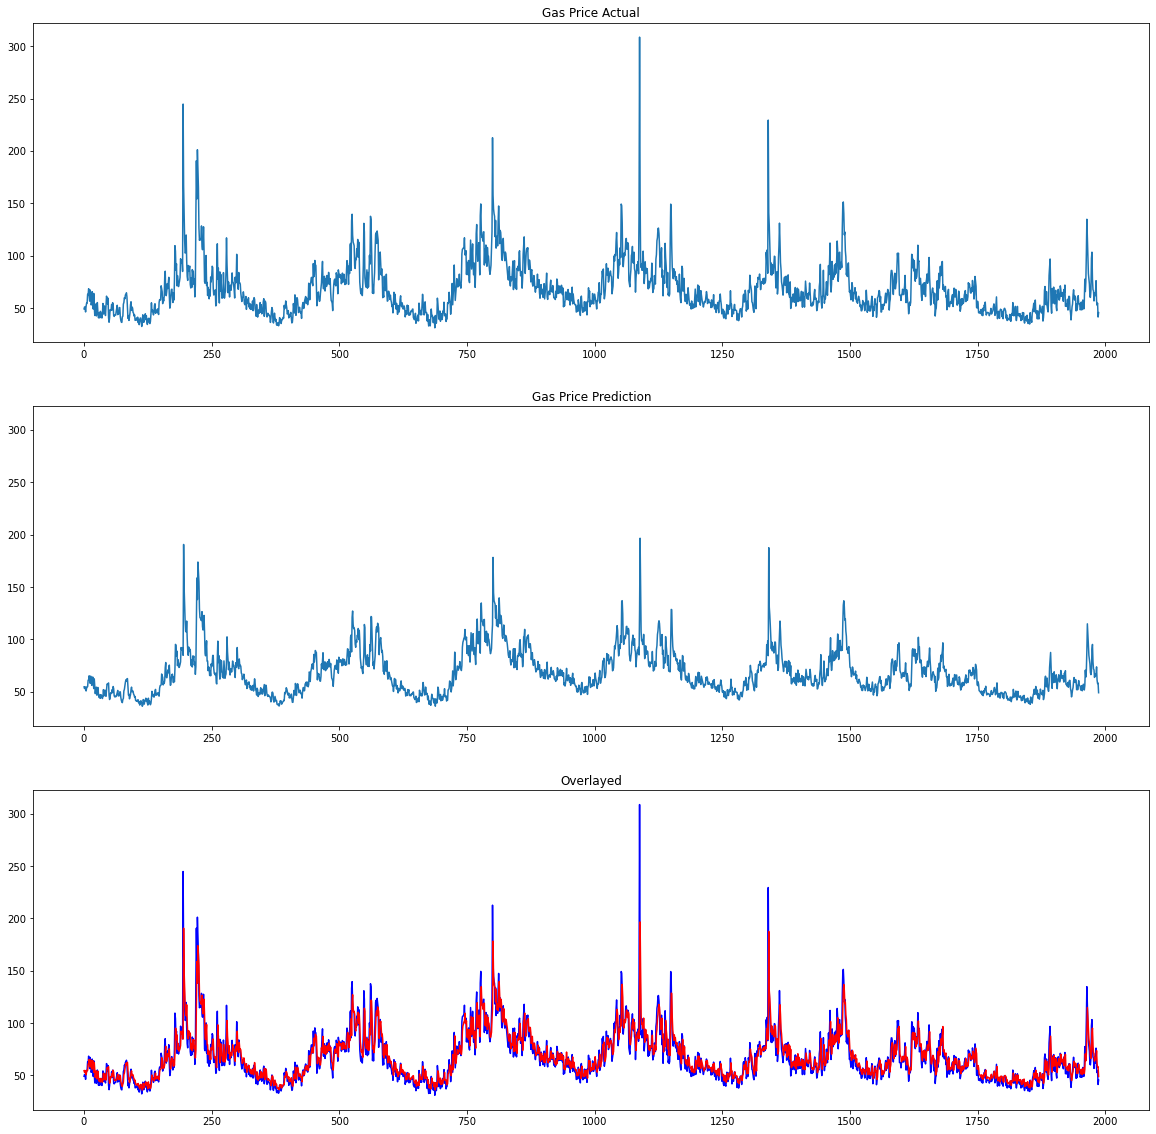

In [47]:
#Minmax scaler has been fit with nd data, add dummy columns so the scaler can be applied to min gas rpice
pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*(len(inputs))).transpose()[0][0]))[ :, :1]
#groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*(len(inputs))).transpose()[0][0]))[ :, :1]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(20)
ax1.plot(groud_truth_descaled)
ax1.title.set_text('Gas Price Actual')
ax2.plot(pred_descaled)
ax2.title.set_text('Gas Price Prediction')
ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

# Lets look at the 10 step lookahead

Resample the datetime to 1 day resolution for axis labels

In [219]:
#Generate Validation Data
n_step_lookahead = 10
X_train2, y_train2, X_val2, y_val2, scaler2 = generate_training_val_examples_no_limits()

In [337]:
resample_rate = '1440T'

In [338]:
data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data = data.resample(resample_rate).mean()
data['datetime'] = data.index
data['datetime'] = data['datetime'].apply(lambda t: t.strftime('%d-%m %H:%M'))

In [341]:
plt.rcParams.update({'font.size': 20})

RMSE 17.333487869413283
MAE 12.040313551470451
MAPE 0.1821307977770858
R^2 0.48576183444327203


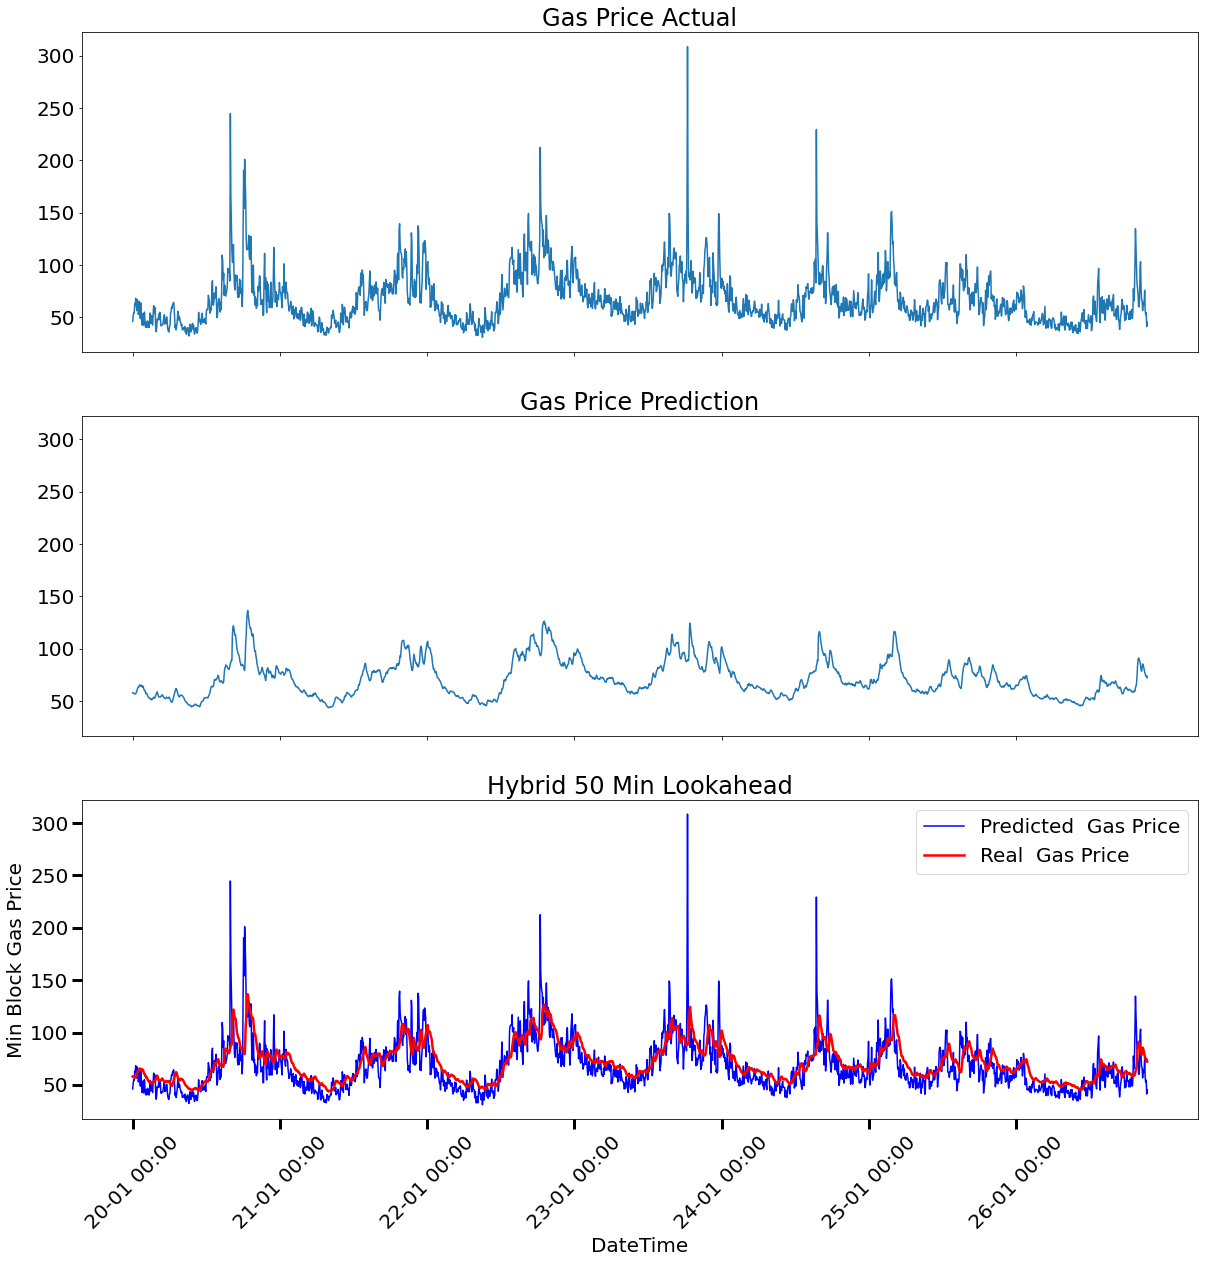

In [352]:
#Minmax scaler has been fit with nd data, add dummy columns so the scaler can be applied to min gas rpice
#Specify Fianl element in our list of forecasts, y_hat_list[-1] to get the 10  step lookahead
pred_descaled= (scaler.inverse_transform(array([y_hat_list[-1],]*(len(inputs))).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*(len(inputs))).transpose()[0][0]))[ :, :1]
#groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*(len(inputs))).transpose()[0][0]))[ :, :1]

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, sharex=True)
f.set_figwidth(20)
f.set_figheight(20)


ax1.plot(groud_truth_descaled)
plt.xticks
ax1.title.set_text('Gas Price Actual')
ax2.plot(pred_descaled)

ax2.title.set_text('Gas Price Prediction')

ax3.set_xticks(np.arange(0, 1985, 288, dtype=None))
ax3.set_xticklabels(data['datetime'].tail(7).values.tolist(), rotation = 45)
ax3.tick_params(length=10, width=3)
ax3.title.set_text('Hybrid 50 Min Lookahead')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='Real '+' Gas Price', linewidth=2.5)
ax3.legend(loc='upper right')
ax3.set_xlabel('DateTime')
ax3.set_ylabel('Min Block Gas Price')




print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))